This example shows how to use the function create_animation (found in modules/plotter.py) to create a mp4 file animation of a time-lapse for 3D data. 

In [1]:
import xarray as xr
import numpy as np
from IPython.display import Video
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cmocean

import sys
sys.path.append('../modules')
from plotter import create_animation
import nclcmaps as nclc

In [2]:
plt.rcParams['animation.ffmpeg_path'] = '/home/sbarc/students/nash/miniconda3/envs/pyclivac/bin/ffmpeg'

In [3]:
import matplotlib.animation as manimation
# import ffmpeg
manimation.writers.list()
# manimation.writers['ffmpeg']

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

### IVT data

In [4]:
# Set filepath
arcase = '200201'
datdir = '/home/nash/DATA/data/'
filename = 'ERA5/era5_hma_025deg_1hr_ivt_{0}_{1}.nc'.format(arcase, arcase[:4])
filepath = datdir + filename

# Open dataset using xarray
ds = xr.open_dataset(filepath)

## ivt data
rename_dict_ivt = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn',
                   'mtpr': 'prec',
                   'latitude': 'lat',
                   'longitude': 'lon'}

ds = ds.rename(rename_dict_ivt) # rename variables to something easier to understand
ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2)) # calculate IVT magnitude
ds = ds.assign(prec=lambda ds: ds.prec*3600) # convert to mm hour-1
ds = ds.assign(prec_cum=lambda ds: ds.prec.cumsum(dim='time')) # calculate precipitation accumulation
ds = ds.reindex(lat=list(reversed(ds.lat))) # make it so lats are -90 to 90

# set these for the animation function
ds.ivt.attrs['long_name'] = 'IVT'
ds.ivt.attrs['units'] = 'IVT (kg m$^{-1}$ s$^{-1}$)'

ds.prec_cum.attrs['long_name'] = 'Accumulated Precipitation'
ds.prec_cum.attrs['units'] = 'Precipitation (mm)'

### add geopotential height data
# Set filepath
datdir = '/home/nash/DATA/data/'
filename = 'ERA5/era5_hma_025deg_1hr_250z_{0}_{1}.nc'.format(arcase, arcase[:4])
filepath = datdir + filename

# Open dataset using xarray
ds2 = xr.open_dataset(filepath)

rename_dict_upper = {'z': 'H', 
                     'latitude': 'lat',
                     'longitude': 'lon'}

ds2 = ds2.rename(rename_dict_upper) # rename variables to something easier to understand
ds2 = ds2.reindex(lat=list(reversed(ds2.lat))) # make it so lats are -90 to 90
ds2 = ds2.assign(H=lambda ds2: ds2.H/(9.80665*10)) # convert to geopotential height (dam)
ds2.H.attrs['long_name'] = '250 hPa Geopotential Heights'
ds2.H.attrs['units'] = 'Geopotential Heights (dam)'
# merge ds together
ds_final = xr.merge([ds, ds2])
ds_final

<xarray.Dataset>
Dimensions:   (lat: 201, lon: 441, time: 120)
Coordinates:
  * lat       (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 49.0 49.25 49.5 49.75 50.0
  * lon       (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 109.2 109.5 109.8 110.0
  * time      (time) datetime64[ns] 2002-01-10 ... 2002-01-14T23:00:00
Data variables:
    ivtn      (time, lat, lon) float32 83.93 75.87 69.25 ... -4.087 -4.713
    ivte      (time, lat, lon) float32 -243.0 -238.8 -234.8 ... 9.632 9.632
    prec      (time, lat, lon) float32 0.2027 0.2386 ... 0.0004677 0.0009337
    ivt       (time, lat, lon) float32 257.1 250.6 244.8 ... 10.22 10.46 10.72
    prec_cum  (time, lat, lon) float32 0.2027 0.2386 0.3778 ... 5.454 5.553
    H         (time, lat, lon) float32 1.096e+03 1.096e+03 ... 984.2 984.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-08 22:26:38 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

/home/sbarc/students/nash/miniconda3/envs/pyclivac/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/sbarc/students/nash/miniconda3/envs/pyclivac/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
../modules/plotter.py:464: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(first_contour, orientation='vertical', cmap=cmap1, shrink=0.99)
../modules/plotter.py:374: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

NameError: name 'filename' is not defined

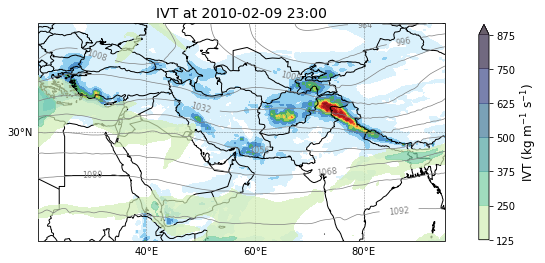

In [5]:
# choose variable from dataset
var1 = 'ivt'
var2 = 'H'
var3 = 'prec_cum'

# set levels for contour plot
clevs1 = np.arange(125, 1000, 125) # levels for filled contours
clevs2 = np.arange(840, 1280, 12) # levels for contour lines
clevs3 = np.arange(2, 250, 25) # levels for filled contours

# set cmap for contour plot
cmap1 = cmo.deep
cmap2 = None
cmap3 = nclc.cmap('WhiteBlueGreenYellowRed')
# run animation function (Note: this may take a few minutes)
new_animation = create_animation(ds_final, var1, var2, var3, clevs1, clevs2, clevs3, cmap1, cmap2, cmap3, ext=[20., 95., 10., 50.])
# show mp4 file in notebook
Video(new_animation)